<a href="https://colab.research.google.com/github/marinacer/IA048/blob/main/glass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as sk
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [90]:
# open the csv file to dataframe
df = pd.read_csv('glass.csv')
df.head()

# atributes to X and labels to y
X = df.drop('Type',axis = 1)
y = df.Type
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [91]:
# label encoding. necessário para corrigir um erro do dataset na nomenclatura das classes
label = preprocessing.LabelEncoder()
label.fit(y)
y_label = label.transform(y)

In [92]:
from sklearn.model_selection import train_test_split

#Xtrain1, Xtest, ytrain1, ytest = train_test_split(X, y_label, test_size = 0.30, random_state = 1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size = 0.30, stratify = y)

**Oversampling**

In [93]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
Xtrain, ytrain = oversample.fit_resample(Xtrain1, ytrain1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Random Forest**

F1medida =  0.9420332911381504


Text(0.5, 1.0, 'Accuracy Score: 0.9231')

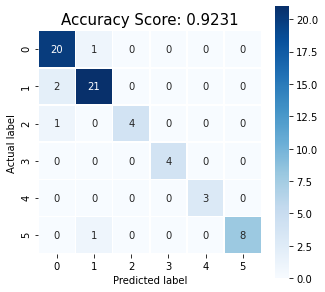

In [94]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(Xtrain, ytrain)
y_ran = clf.predict(Xtest)

f1_ran = f1_score(ytest, y_ran, average='macro')
cmatrix_ran = sk.confusion_matrix(ytest,y_ran)
print('F1medida = ', f1_ran)

plt.figure(figsize=(5,5))
sns.heatmap(cmatrix_ran, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest,y_ran))
plt.title(all_sample_title, size = 15)

**KNN**

F1medida =  0.9033670033670033


Text(0.5, 1.0, 'Accuracy Score: 0.8923')

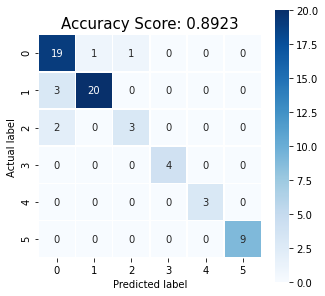

In [95]:
# para Xtrain e Xtest
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors = 1)
neigh.fit(Xtrain, ytrain)
y_knn = neigh.predict(Xtest)

f1_knn = f1_score(ytest, y_knn, average='macro')
cmatrix_knn = sk.confusion_matrix(ytest,y_knn)
print('F1medida = ', f1_knn)

plt.figure(figsize=(5,5))
sns.heatmap(cmatrix_knn, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest,y_knn))
plt.title(all_sample_title, size = 15)

F1medida para k =  1 :  0.9033670033670033
Matriz de confusão para k =  1
[[19  1  1  0  0  0]
 [ 3 20  0  0  0  0]
 [ 2  0  3  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  3  0]
 [ 0  0  0  0  0  9]]

F1medida para k =  2 :  0.8040380630050644
Matriz de confusão para k =  2
[[20  1  0  0  0  0]
 [ 7 16  0  0  0  0]
 [ 4  0  1  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  3  0]
 [ 0  1  0  0  0  8]]

F1medida para k =  3 :  0.741310089927444
Matriz de confusão para k =  3
[[19  2  0  0  0  0]
 [ 4 17  0  0  2  0]
 [ 4  0  1  0  0  0]
 [ 0  1  0  3  0  0]
 [ 0  0  0  0  3  0]
 [ 1  0  0  0  0  8]]

F1medida para k =  4 :  0.6797415547415548
Matriz de confusão para k =  4
[[20  0  1  0  0  0]
 [ 7 14  0  0  2  0]
 [ 4  0  1  0  0  0]
 [ 0  1  0  2  0  1]
 [ 0  0  0  0  3  0]
 [ 0  1  0  0  0  8]]

F1medida para k =  5 :  0.6484284016636958
Matriz de confusão para k =  5
[[19  2  0  0  0  0]
 [ 4 17  0  0  2  0]
 [ 5  0  0  0  0  0]
 [ 0  2  0  2  0  0]
 [ 0  0  0  0  3  0]
 [ 1  0  0  0 

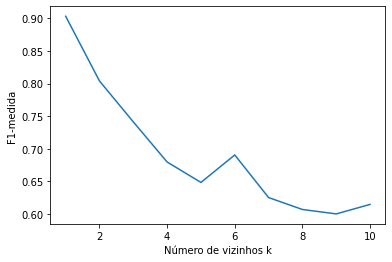

In [96]:
F1medida_knn_2 = []
nknn = 11
for i in range(1,nknn):
    neigh_2 = KNeighborsClassifier(n_neighbors = i)
    neigh_2.fit(Xtrain, ytrain)
    y_knn_2 = neigh_2.predict(Xtest)

    F1medida_knn_2.append(f1_score(ytest, y_knn_2, average='macro'))
    print('F1medida para k = ',i, ': ', F1medida_knn_2[i-1])
    print('Matriz de confusão para k = ', i)
    print(sk.confusion_matrix(ytest,y_knn_2))
    print()
plt.plot(range(1,nknn),F1medida_knn_2)
plt.xlabel('Número de vizinhos k');
plt.ylabel('F1-medida');
pass

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

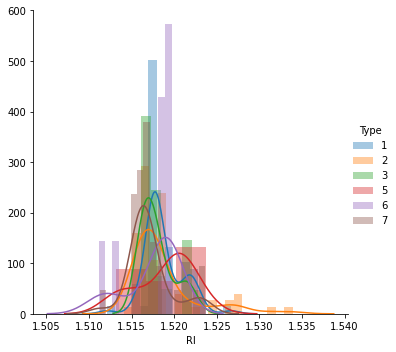

In [97]:
sns.FacetGrid(df,hue="Type",height=5).map(sns.distplot,"RI").add_legend();

In [ ]:
# cálculo das amostras por classe para o gráfico
unique, counts = np.unique(y, return_counts=True)
print("Quantidade de amostras total:",counts)

unique, counts = np.unique(ytest, return_counts=True)
print("Quantidade de amostras treino:",counts)

unique, counts = np.unique(ytrain, return_counts=True)
print("Quantidade de amostras teste:",counts)

Quantidade de amostras total: [70 76 17 13  9 29]
Quantidade de amostras treino: [25 21  7  2  1  9]
Quantidade de amostras teste: [45 55 10 11  8 20]


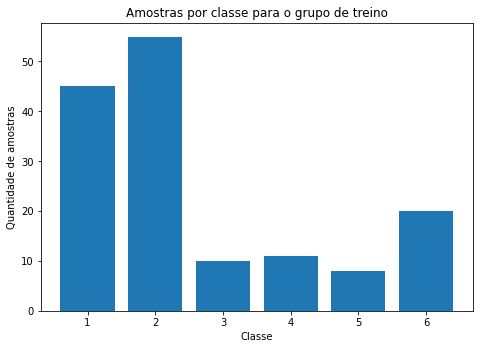

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([1,2,3,4,5,6],[45,55,10,11,8,20])
plt.title("Amostras por classe para o grupo de treino")
plt.xlabel("Classe")
plt.ylabel("Quantidade de amostras")
plt.show()

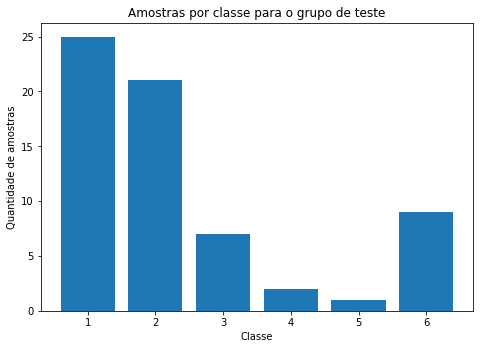

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([1,2,3,4,5,6],[25,21,7,2,1,9])
plt.title("Amostras por classe para o grupo de teste")
plt.xlabel("Classe")
plt.ylabel("Quantidade de amostras")
plt.show()

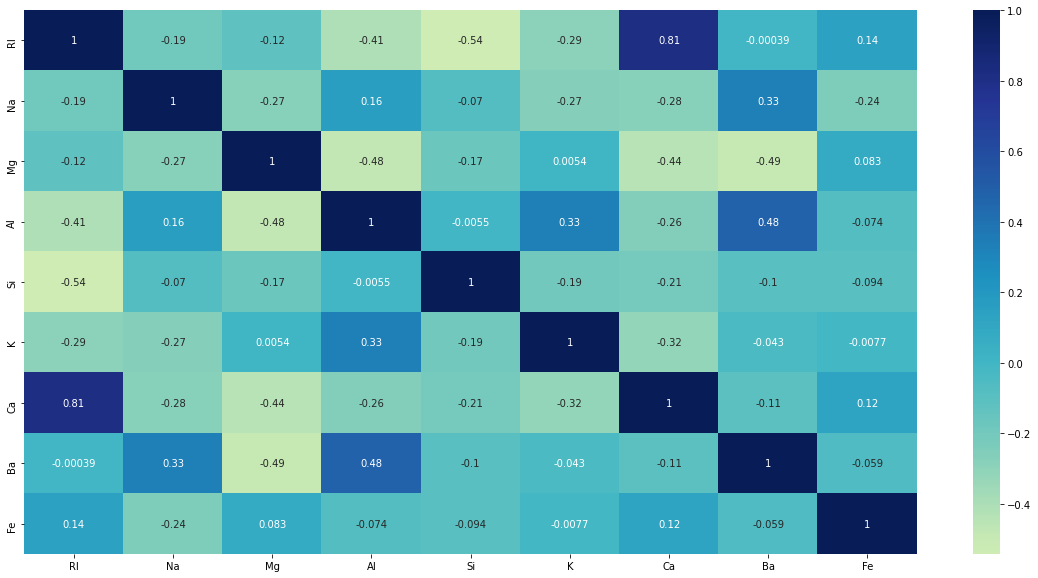

In [ ]:
corrMatrix = X.corr()
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, ax=ax,cmap="YlGnBu", center = 0)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


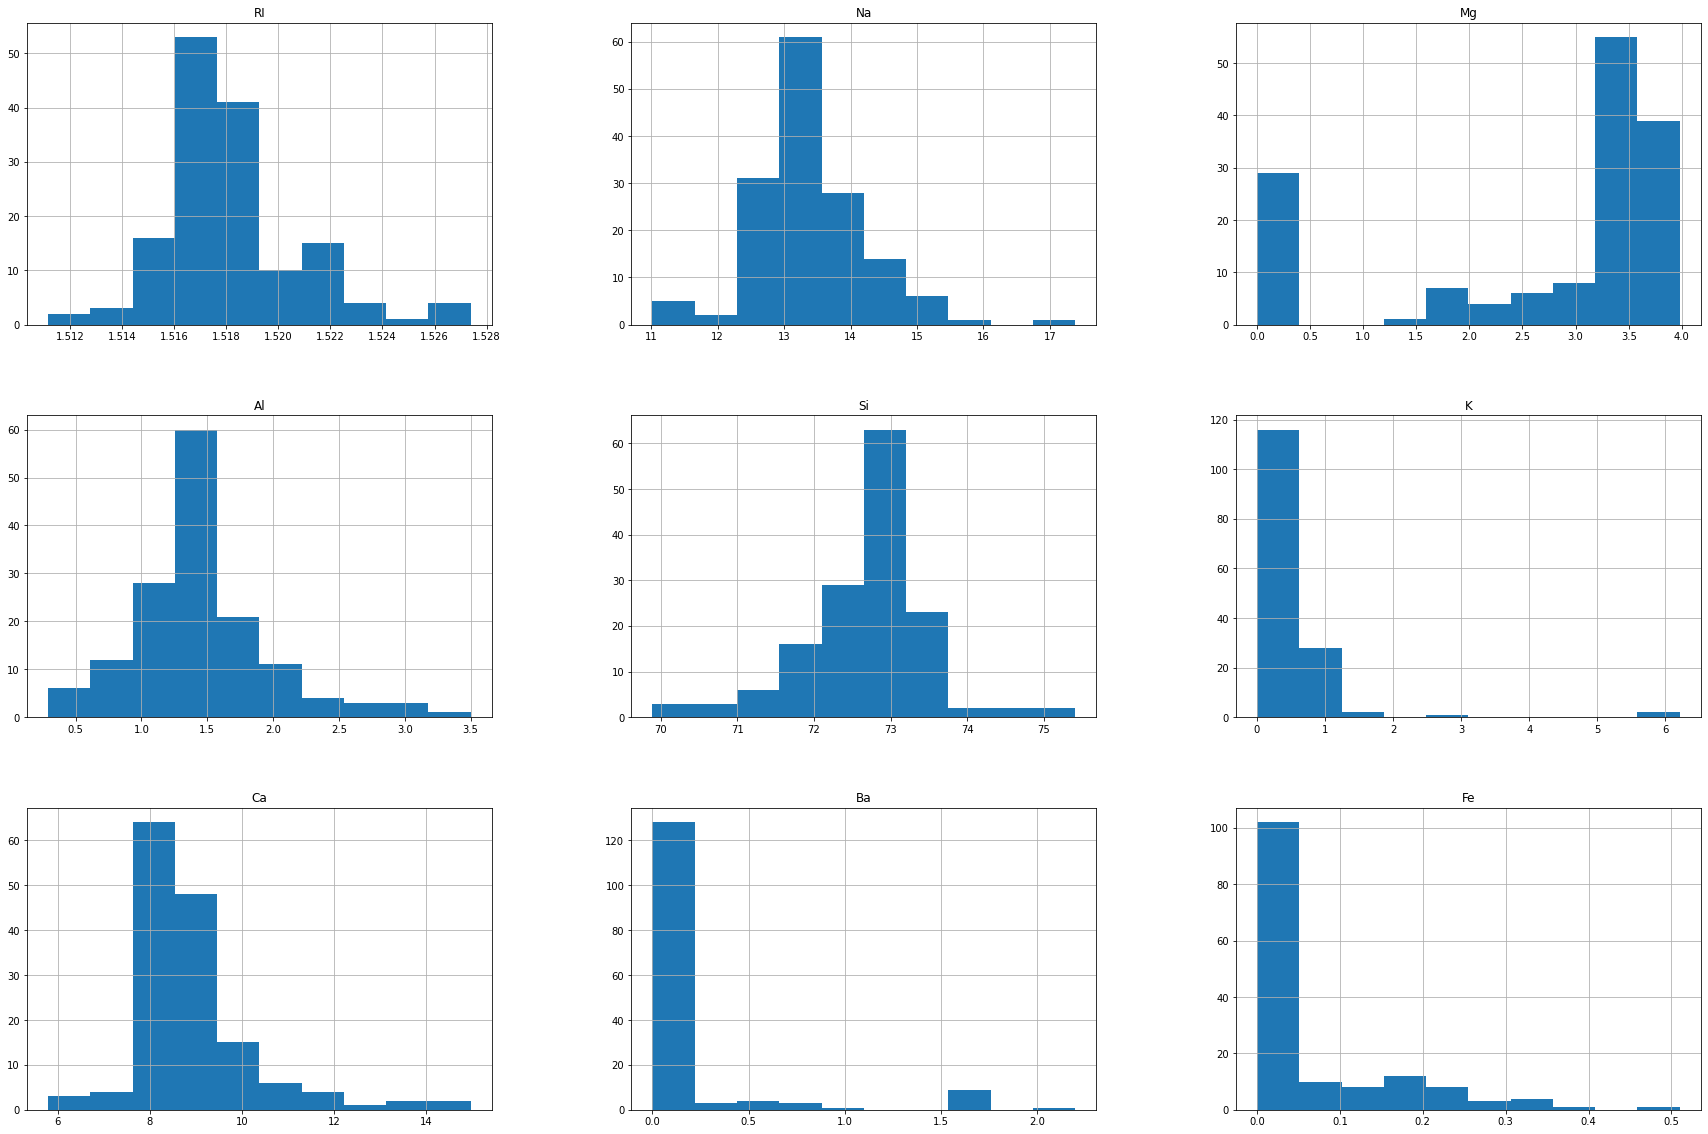

In [ ]:
Xtrainpd = pd.DataFrame(Xtrain)
fig, ax = plt.subplots(figsize=(30,20)) 
Xtrainpd.hist(ax = ax)
pass

In [ ]:
#KNN 0.32
#random 0.29

**SVC**

F1medida =  0.676500143554407


Text(0.5, 1.0, 'Accuracy Score: 0.7692')

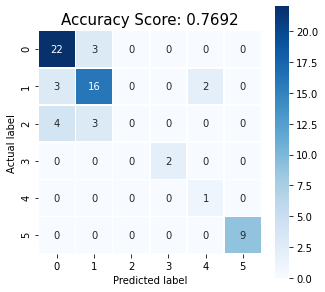

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(Xtrain, ytrain)
y_svc = clf.predict(Xtest)

f1_svc = f1_score(ytest, y_svc, average='macro')
cmatrix_svc = sk.confusion_matrix(ytest,y_svc)
print('F1medida = ', f1_svc)

plt.figure(figsize=(5,5))
sns.heatmap(cmatrix_svc, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest,y_svc))
plt.title(all_sample_title, size = 15)

**Logistic Regression**

F1medida =  0.4509178743961353


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 1.0, 'Accuracy Score: 0.6615')

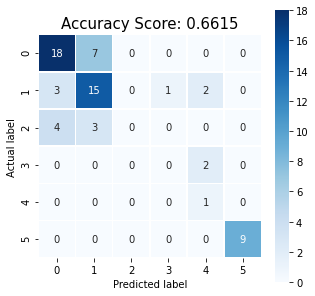

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

reg = LogisticRegression(fit_intercept=True).fit(Xtrain,ytrain)
y_reg = reg.predict(Xtest)

f1_reg = f1_score(ytest, y_reg, average='macro')
cmatrix_reg = sk.confusion_matrix(ytest,y_reg)
print('F1medida = ', f1_reg)

plt.figure(figsize=(5,5))
sns.heatmap(cmatrix_reg, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest,y_reg))
plt.title(all_sample_title, size = 15)

**MLP**

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X, y_label, test_size = 0.20, stratify = y)

feature_vector_length = Xtrain.shape[1]
num_classes = 6
input_shape = (feature_vector_length,)
ytrain2 = to_categorical(ytrain2, 6)
ytest2 = to_categorical(ytest2, 6)

In [ ]:
#Nneuronios = list(range(1,25))
#listacc = []
#for i in Nneuronios:
#    model = Sequential()
#    model.add(Dense(i, input_shape=input_shape))
#    model.add(LeakyReLU(alpha=0.1))
#    model.add(Dense(num_classes, activation='softmax'))
#    Nepochs = 1000
#    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0005, verbose=1, patience=50)
#    result = model.fit(Xtrain2, ytrain2, epochs=Nepochs, batch_size=50, verbose=1, validation_data=(Xtest2,ytest2), callbacks=[es])
#    accuracy = model.evaluate(Xtest2, ytest2, verbose=1)[1]
#    listacc.append(accuracy)

#listacc = np.array(listacc)
#plt.plot(Nneuronios, listacc)
#plt.xlabel('Nº de neurônios na camada oculta')
#plt.ylabel('Acurácia')
#plt.show()